# FingersCounter

CNN multiclass classifier for counting number of fingers shown on one hand. Made with EduNet.

By Matas Gumbinas, 2019

## Introduction & acknowledgements

The sole goal of this work is to demonstrate **EduNet** NN (neural networks) modeling framework [1].  
For this task a Kaggle dataset "Fingers" by Pavel Koryakin [2] was used. The purpose of this  
dataset is to help create an image classifier that would count fingers on a hand from 0 to 5.

Results:  
During this work, using EduNet API, a Convolution Neural Network was created to be trained on the  
given dataset. Afterwards, the trained model was tested using unused part of the dataset meant for   
testing the trained models. The trained model reached 100% accuracy with both, training and validation  
datasets, while running it on testing data an accuracy of 99.97% was achieved.

List of references:  
1. EduNet. Numpy based educational neural networks modeling framework - from scratch  
(by Matas Gumbinas).  
https://github.com/gMatas/edunet
2. "Fingers" dataset (by Pavel Koryakin).  
https://www.kaggle.com/gmatas/account

## Starting up

First, download EduNet python package from github [1] (v1.3.0-alpha.0 release) to the main  
directory (at ```fingers-counter/```). Or run the following git commands from your console/terminal  
starting from the main directory: 
```shell
git clone https://github.com/gmatas/edunet
cd edunet
git checkout v1.3.0-alpha.0
cd ..
```

Next, from the project main directory run the following pip command to install the required python  
dependencies for running this notebook:
```shell
pip install -r requirements.txt
```

Finaly, before running this notebook, please run the following commands:  
```shell
cd datasets
python fingers.py
cd ..
```

```fingers.py``` script will unzip "fingers.zip" file and read its contents to original "**fingers**" dataset. Afterwards  
it will generate a downsampled version of it to a directory "**fingers_32x32**". The following work will be done on  
the downsampled dataset.

## Dataset initialization

In [ ]:
from typing import Dict, List, Tuple, Iterable, Optional
import os
import sys
import math
import pickle

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

assert os.path.isdir('edunet'), 'Can not find directory "edunet" in the working directory.'
sys.path.append('edunet')
import edunet as en

from mytools import ProgressBar

In [2]:
FINGERS32_PATH = 'datasets\\fingers_32x32\\'
FINGERS32_TRAIN_PATH = os.path.join(FINGERS32_PATH, 'train')
FINGERS32_TEST_PATH = os.path.join(FINGERS32_PATH, 'test')

In [3]:
def build_dataset_dataframe_from_path(dirpath: str):
    filenames = os.listdir(dirpath)
    
    i_array = 0
    filenames_array = [''] * len(filenames)   
    fingercount_array = np.empty([len(filenames)], np.uint8)
    handside_array = [''] * len(filenames)
    
    image_extensions = {'png', 'jpg', 'jpeg'}
    
    for filename in filenames:
        parts = filename.split('.')
        if len(parts) < 2:
            continue

        name = '.'.join(parts[:-1])
        ext = parts[-1]
        if ext.lower() not in image_extensions:
            continue

        filename_parts = filename.split('.')
        filelabel = filename_parts[0].split('_')[-1]
        fingercount = filelabel[:-1]
        handside = filelabel[-1]
        
        filenames_array[i_array] = filename
        fingercount_array[i_array] = fingercount
        handside_array[i_array] = handside
        i_array += 1
    
    return pd.DataFrame(data={
        'Filename': filenames_array[:i_array],
        'FingersCount': fingercount_array[:i_array],
        'HandSide': handside_array[:i_array]
    }) 

In [4]:
train_dataset_df = build_dataset_dataframe_from_path(FINGERS32_TRAIN_PATH)
train_dataset_df

,Filename,FingersCount,HandSide
0,00048bba-979b-4f84-b833-5bbbb082b582_0L.png,0,L
1,000547a2-d456-4b16-b351-12ca9b40e390_0L.png,0,L
2,000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8_2L.png,2,L
3,000d9961-8136-4dee-9820-86e178777958_0L.png,0,L
4,0010095b-2e3d-4517-a511-1f688c378f96_5L.png,5,L
...,...,...,...
17995,ffed5de7-577a-49f8-8912-a51ca5ec2ce7_0L.png,0,L
17996,ffef96a9-fe26-4e07-816f-23385af4fbdb_4L.png,4,L
17997,fff5517f-6329-4588-b0a7-fa41ca820840_0R.png,0,R
17998,fff79b8e-4d29-4cfa-bba8-687ba60f4e98_2L.png,2,L


In [5]:
test_dataset_df = build_dataset_dataframe_from_path(FINGERS32_TEST_PATH)
test_dataset_df

,Filename,FingersCount,HandSide
0,000e7aa6-100b-4c6b-9ff0-e7a8e53e4465_5L.png,5,L
1,001f6021-8581-4ed2-aed4-cda0af1d5d57_5L.png,5,L
2,0027029b-4c3c-4785-bc1b-b8141331a108_3R.png,3,R
3,004599fb-c735-4ff3-a969-342dda319382_5L.png,5,L
4,00500e1a-f4bd-4f66-9eb8-c7fce19a3f6f_5L.png,5,L
...,...,...,...
3595,ff78cf4f-d03c-4b41-9dbc-03bdfdf241bf_2R.png,2,R
3596,ff8be861-dd82-4500-893f-e9b6e299c5e1_0L.png,0,L
3597,ff9eeef5-2c62-4bce-9d29-587345a7acfe_4R.png,4,R
3598,ffb7e43c-deac-4b8f-83bf-44437104c35d_3R.png,3,R


## Dataset analysis

Dataset grouping by finger count and hand side, to make sure that there would be no biases steming from  
unproportionate distribution of classes.

### Training data preparation & analysis

In [6]:
train_dataset_df.groupby('FingersCount').count()

,Filename,HandSide
FingersCount,,
0,3000,3000
1,3000,3000
2,3000,3000
3,3000,3000
4,3000,3000
5,3000,3000


In [7]:
train_dataset_df.groupby('HandSide').count()

,Filename,FingersCount
HandSide,,
L,9000,9000
R,9000,9000


In [8]:
n_valid_samples = 120
seed = 4658976

train_df = train_dataset_df.sample(frac=1., random_state=seed)

train_df, valid_df = train_test_split(train_df, test_size=120, shuffle=False)

print('train samples:', len(train_df))
print('valid samples:', len(valid_df))

train samples: 17880
valid samples: 120


In [9]:
train_df

,Filename,FingersCount,HandSide
16990,f1918855-56e0-4a06-ad80-776019d3a3b5_1R.png,1,R
2535,231a27d6-815b-4ce9-a3cd-b04985aff8d7_4L.png,4,L
3253,2d100518-91fa-453a-82c2-7345ded50d93_0R.png,0,R
7337,6715ac27-1d9b-4c62-92d7-12d88d41fc7c_1R.png,1,R
9465,8598a454-5e1b-4448-88de-00ece2dfd30c_4R.png,4,R
...,...,...,...
4553,3f4f3a88-4fb7-4fbf-b046-ec5fe44330d9_0R.png,0,R
10122,8f1de7da-7a18-432d-b78f-ee419bcfff76_3L.png,3,L
3701,3378a999-1adb-4711-b1b7-5cfd265b0fd4_4L.png,4,L
12412,b0bb0e66-baa8-4c01-9d2a-39bbce812691_0R.png,0,R


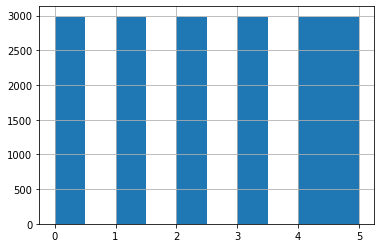

In [10]:
train_df.FingersCount.hist();

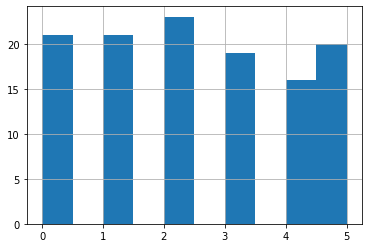

In [11]:
valid_df.FingersCount.hist();

### Testing data preparation & analysis

In [12]:
test_dataset_df.groupby('FingersCount').count()

,Filename,HandSide
FingersCount,,
0,600,600
1,600,600
2,600,600
3,600,600
4,600,600
5,600,600


In [13]:
test_dataset_df.groupby('HandSide').count()

,Filename,FingersCount
HandSide,,
L,1800,1800
R,1800,1800


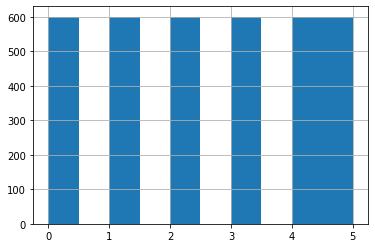

In [14]:
test_dataset_df.FingersCount.hist();

## FingersCounter model

In [1]:
class FingersCounter(object):
    
    N_CATEGORIES = 6
    
    def __init__(self, data_size: Iterable[int], labels_size: Iterable[int], dtype: np.dtype, learning_rate: float, random_state=None):
        self.__data_size = data_size
        self.__labels_size = labels_size
        self.__dtype = dtype
        self.__learning_rate = 0.01
        self.__graph = en.Graph()
        self.__ops_map: Dict[str, en.Operation] = dict()
        self.__random_state = np.random.RandomState() if random_state is None else random_state
        
    @classmethod
    def load(cls, filepath: str):
        with open(filepath, 'rb') as fs:
            obj = pickle.load(fs)
        
        assert isinstance(obj, FingersCounter)
        
        instance = cls(obj.__data_size, obj.__labels_size, obj.__dtype, obj.__learning_rate, obj.__random_state)
        instance.__graph = obj.__graph
        instance.__ops_map = obj.__ops_map
        return instance
        
    @property
    def graph(self) -> en.Graph:
        return self.__graph
        
    def get_operation_by_name(self, name: str) -> en.Operation:
        return self.__ops_map[name]
    
    def get_operations_names(self) -> List[en.Operation]:
        return list(self.__ops_map.keys())
    
    def drop_operation_by_name(self, name: str):
        op = self.__ops_map.pop(name)
        self.__graph.remove(op)
        return op
    
    def build(self):
        batch_size = self.__data_size[0]
        
        input_data = en.Input(self.__data_size, self.__dtype)
        input_labels = en.Input([batch_size, FingersCounter.N_CATEGORIES, 1], self.__dtype)
        
        conv_1_1 = en.Convolution2D(input_data, 16, 3, mode='same', weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)
        relu_1_1 = en.Relu(conv_1_1)
        conv_1_2 = en.Convolution2D(relu_1_1, 16, 3, strides=2, mode='valid', weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)
        relu_1_2 = en.Relu(conv_1_2)
        
        conv_2_1 = en.Convolution2D(relu_1_2, 32, 3, mode='same', weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)
        relu_2_1 = en.Relu(conv_2_1)
        conv_2_2 = en.Convolution2D(relu_2_1, 32, 3, strides=2, mode='valid', weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)
        relu_2_2 = en.Relu(conv_2_2)
        
        conv_3_1 = en.Convolution2D(relu_2_2, 64, 3, mode='same', weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)
        relu_3_1 = en.Relu(conv_3_1)
        conv_3_2 = en.Convolution2D(relu_3_1, 64, 3, strides=2, mode='valid', weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)
        relu_3_2 = en.Relu(conv_3_2)
        
        flatten = en.Flatten(relu_3_2)
        
        dense_1 = en.Dense(flatten, 128, weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)
        relu_4 = en.Relu(dense_1)
        
        dense_2 = en.Dense(relu_4, FingersCounter.N_CATEGORIES, weights_initializer=en.initializers.HeNormal, random_state=self.__random_state)

        loss = en.SoftargmaxCrossEntropyWithLogits(input_labels, dense_2)
        reduce_sum = en.ReduceSum(loss)
        
        minimize = en.MomentumOptimizer(self.__learning_rate, gamma=0.9).minimize(reduce_sum)
        
        self.__ops_map = dict((k, v) for k, v in locals().items() if isinstance(v, en.Operation))
        self.__graph.extend(self.__ops_map.values())
        
    def freeze(self, batch_size: int = 1):
        self.__data_size = (batch_size, *data_size[1:])
        
        input_data = en.Input(self.__data_size, self.__dtype)
        
        conv_1_1 = en.Convolution2D(input_data, 16, 3, mode='same', random_state=self.__random_state)
        relu_1_1 = en.Relu(conv_1_1)
        conv_1_2 = en.Convolution2D(relu_1_1, 16, 3, strides=2, mode='valid', random_state=self.__random_state)
        relu_1_2 = en.Relu(conv_1_2)
        
        conv_2_1 = en.Convolution2D(relu_1_2, 32, 3, mode='same', random_state=self.__random_state)
        relu_2_1 = en.Relu(conv_2_1)
        conv_2_2 = en.Convolution2D(relu_2_1, 32, 3, strides=2, mode='valid', random_state=self.__random_state)
        relu_2_2 = en.Relu(conv_2_2)
        
        conv_3_1 = en.Convolution2D(relu_2_2, 64, 3, mode='same', random_state=self.__random_state)
        relu_3_1 = en.Relu(conv_3_1)
        conv_3_2 = en.Convolution2D(relu_3_1, 64, 3, strides=2, mode='valid', random_state=self.__random_state)
        relu_3_2 = en.Relu(conv_3_2)
        
        flatten = en.Flatten(relu_3_2)
        
        dense_1 = en.Dense(flatten, 128, random_state=self.__random_state)
        relu_4 = en.Relu(dense_1)
        
        dense_2 = en.Dense(relu_4, FingersCounter.N_CATEGORIES, random_state=self.__random_state)
        softmax = en.SoftArgMax(dense_2, 1)
        
        # Set trained variables to the newely initialized operations.
        conv_1_1.var_list = self.__ops_map['conv_1_1'].var_list
        conv_1_2.var_list = self.__ops_map['conv_1_2'].var_list
        conv_2_2.var_list = self.__ops_map['conv_2_2'].var_list
        conv_3_1.var_list = self.__ops_map['conv_3_1'].var_list
        conv_3_2.var_list = self.__ops_map['conv_3_2'].var_list
        dense_1.var_list = self.__ops_map['dense_1'].var_list
        dense_2.var_list = self.__ops_map['dense_2'].var_list
        
        # Clear current graph.
        for op in self.__graph.get_ops():
            self.__graph.remove(op)
        del op
                
        # Fill current graph with new opertions.
        self.__ops_map = dict((k, v) for k, v in locals().items() if isinstance(v, en.Operation))
        self.__graph.extend(self.__ops_map.values())
        
    def save(self, filepath: str):
        with open(filepath, 'wb') as fs:
            pickle.dump(self, fs)
            
    def read(self, filepath: str):
        with open(filepath, 'rb') as fs:
            obj = pickle.load(fs)
        
        assert isinstance(obj, FingersCounter)
        
        self.__data_size = obj.__data_size
        self.__labels_size = obj.__labels_size
        self.__dtype = obj.__dtype
        self.__learning_rate = obj.__learning_rate
        self.__graph = obj.__graph
        self.__ops_map = obj.__ops_map
        self.__random_state = obj.__random_state

In [81]:
def create_batch_generator(dataset: pd.DataFrame, dataset_path: str, batch_size: int, image_size: Tuple[int, int], is_gray: bool, dtype: np.dtype, n_categories: int):
    data_batch = np.empty((batch_size, *image_size, (1 if is_gray else 3)), dtype)
    labels_batch = np.empty((batch_size, n_categories, 1), dtype)

    current_sample = 0
    is_batch_empty = True

    for row in dataset.itertuples():
        imagepath = os.path.join(dataset_path, row.Filename)
        image = cv2.imread(imagepath, (cv2.IMREAD_GRAYSCALE if is_gray else cv2.IMREAD_COLOR))
        if image is None:
            continue

        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = np.float32(image) / 255
        if is_gray:
            data_batch[current_sample] = image[..., None]

        label = int(row.FingersCount)
        categorical_label = [0 for _ in range(n_categories)]
        categorical_label[label] = 1
        labels_batch[current_sample, :, 0] = categorical_label

        current_sample += 1
        is_batch_empty = False

        if current_sample % batch_size == 0:
            current_sample = 0
            is_batch_empty = True
            yield data_batch, labels_batch

    if not is_batch_empty:
        data_batch = data_batch[:current_sample]
        labels_batch = labels_batch[:current_sample]
        yield data_batch, labels_batch

## FingersCounter classifier training  

In [82]:
def train(
    fc: FingersCounter, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    n_epochs: int, 
    batch_size: int, 
    image_size: Tuple[int, int],
    is_gray: bool,
    dtype: np.dtype,
    model_name: str,
    model_dirpath: str,
    seed=None
):    
    input_data_op = fc.get_operation_by_name('input_data')
    input_labels_op = fc.get_operation_by_name('input_labels')
    dense_2_op = fc.get_operation_by_name('dense_2')
    loss_op = fc.get_operation_by_name('loss')
    minimize_op = fc.get_operation_by_name('minimize')
    
    flow = en.Flow(fc.graph)
    
    n_batches = int(math.ceil(len(train_df) / batch_size))
    progressbar = ProgressBar(n_batches, name='batch')
        
    for epoch in range(n_epochs):
        is_accum_full = False
        accum_counter = 0
        accum_size = 500
        epoch_loss_accum = [0 for _ in range(accum_size)]
        epoch_accuracy_accum = [0 for _ in range(accum_size)]
        
        
        sampled_train_df = train_df.sample(frac=1.0, random_state=seed)
        batch_gen = create_batch_generator(sampled_train_df, FINGERS32_TRAIN_PATH, batch_size, image_size, is_gray, dtype, FingersCounter.N_CATEGORIES)
        for data_batch, labels_batch in batch_gen:            
            input_labels, dense_2, loss, _ = flow.run([input_labels_op, dense_2_op, loss_op, minimize_op], feed_dict={
                input_data_op: data_batch,
                input_labels_op: labels_batch
            })

            softmax_output = en.core.math.softargmax(dense_2, 1)

            epoch_loss_accum[accum_counter] = np.mean(loss)
            epoch_accuracy_accum[accum_counter] = np.equal(np.argmax(softmax_output, axis=1), np.argmax(input_labels, axis=1)).astype(np.float32).mean()
            accum_counter += 1

            if is_accum_full:
                epoch_loss_mean = round(sum(epoch_loss_accum) / accum_size, 4) if accum_size != 0 else 0.
                epoch_accuracy_mean = round(sum(epoch_accuracy_accum) / accum_size, 4) if accum_size != 0 else 0.
                if accum_counter >= accum_size:
                    accum_counter = 0
            else:
                epoch_loss_mean = round(sum(epoch_loss_accum[:accum_counter]) / accum_counter, 4) if accum_counter != 0 else 0.
                epoch_accuracy_mean = round(sum(epoch_accuracy_accum[:accum_counter]) / accum_counter, 4) if accum_counter != 0 else 0.
                if accum_counter >= accum_size:
                    accum_counter = 0
                    is_accum_full = True

            epoch_loss_mean = round(sum(epoch_loss_accum[:accum_counter]) / accum_counter, 4) if accum_counter != 0 else 0.
            epoch_accuracy_mean = round(sum(epoch_accuracy_accum[:accum_counter]) / accum_counter, 4) if accum_counter != 0 else 0.          
            if accum_counter >= accum_size:
                accum_counter = 0
                is_accum_full = True

            progressbar.make_step()
            progressbar.printout(
                inline=True,
                extra='-- loss: {} -- acc: {}'.format(epoch_loss_mean, epoch_accuracy_mean))

            
        epoch_valid_accum_counter = 0
        epoch_valid_loss_accum = 0
        epoch_valid_accuracy_accum = 0

        batch_gen = create_batch_generator(valid_df, FINGERS32_TRAIN_PATH, batch_size, image_size, is_gray, dtype, FingersCounter.N_CATEGORIES)
        for data_batch, labels_batch in batch_gen:            
            input_labels, dense_2, loss = flow.run([input_labels_op, dense_2_op, loss_op], feed_dict={
                input_data_op: data_batch,
                input_labels_op: labels_batch
            })
            
            softmax_output = en.core.math.softargmax(dense_2, 1)

            epoch_valid_accum_counter += 1
            epoch_valid_loss_accum += np.mean(loss)
            epoch_valid_accuracy_accum += np.equal(np.argmax(softmax_output, axis=1), np.argmax(input_labels, axis=1)).astype(np.float32).mean()

        epoch_valid_loss_mean = round(epoch_valid_loss_accum / epoch_valid_accum_counter, 4) if epoch_valid_accum_counter != 0 else 0.
        epoch_valid_accuracy_mean = round(epoch_valid_accuracy_accum / epoch_valid_accum_counter, 4) if epoch_valid_accum_counter != 0 else 0.

        progressbar.printout(
            counter=False,
            extra='epoch: {} -- train_loss: {} -- train_acc: {} -- valid_loss: {} -- valid_acc: {}'.format(
                epoch+1, epoch_loss_mean, epoch_accuracy_mean, epoch_valid_loss_mean, epoch_valid_accuracy_mean))
        progressbar.reset()

        model_filename = '%s_e%d.%s' % (model_name, epoch+1, 'pkl')
        model_savepath = os.path.join(model_dirpath, model_filename)
        fc.save(model_savepath)

In [61]:
batch_size = 60
input_size = (32, 32)

data_size = (batch_size, *input_size, 1)
labels_size = (batch_size, FingersCounter.N_CATEGORIES, 1)
input_dtype = np.float32

fingerscounter = FingersCounter(data_size, labels_size, input_dtype, learning_rate=0.001)
fingerscounter.build()

In [62]:
for opname in fingerscounter.get_operations_names():
    op = fingerscounter.get_operation_by_name(opname)
    print('{}: ({})  ..  shape: {}  .. dtype: {}'.format(opname, op.name, op.output.shape, op.output.dtype))

input_data: (Input)  ..  shape: (60, 32, 32, 1)  .. dtype: float32
input_labels: (Input)  ..  shape: (60, 6, 1)  .. dtype: float32
conv_1_1: (Convolution2D)  ..  shape: (60, 32, 32, 16)  .. dtype: float32
relu_1_1: (Relu)  ..  shape: (60, 32, 32, 16)  .. dtype: float32
conv_1_2: (Convolution2D)  ..  shape: (60, 15, 15, 16)  .. dtype: float32
relu_1_2: (Relu)  ..  shape: (60, 15, 15, 16)  .. dtype: float32
conv_2_1: (Convolution2D)  ..  shape: (60, 15, 15, 32)  .. dtype: float32
relu_2_1: (Relu)  ..  shape: (60, 15, 15, 32)  .. dtype: float32
conv_2_2: (Convolution2D)  ..  shape: (60, 7, 7, 32)  .. dtype: float32
relu_2_2: (Relu)  ..  shape: (60, 7, 7, 32)  .. dtype: float32
conv_3_1: (Convolution2D)  ..  shape: (60, 7, 7, 64)  .. dtype: float32
relu_3_1: (Relu)  ..  shape: (60, 7, 7, 64)  .. dtype: float32
conv_3_2: (Convolution2D)  ..  shape: (60, 3, 3, 64)  .. dtype: float32
relu_3_2: (Relu)  ..  shape: (60, 3, 3, 64)  .. dtype: float32
flatten: (Flatten)  ..  shape: (60, 576, 1)  ..

In [66]:
n_epochs = 10
model_name = 'fingerscounter'
seed = 69696969

train(fingerscounter, train_df, valid_df, n_epochs, batch_size, input_size, True, input_dtype, model_name, './', seed)

[======================>] epoch: 1 -- train_loss: 0.1371 -- train_acc: 0.949 -- valid_loss: 0.0016 -- valid_acc: 1.0
[======================>] epoch: 2 -- train_loss: 0.0008 -- train_acc: 0.9999 -- valid_loss: 0.0004 -- valid_acc: 1.0
[======================>] epoch: 3 -- train_loss: 0.0001 -- train_acc: 1.0 -- valid_loss: 0.0002 -- valid_acc: 1.0
[======================>] epoch: 4 -- train_loss: 0.0001 -- train_acc: 1.0 -- valid_loss: 0.0001 -- valid_acc: 1.0
[======================>] epoch: 5 -- train_loss: 0.0001 -- train_acc: 1.0 -- valid_loss: 0.0001 -- valid_acc: 1.0
[======================>] epoch: 6 -- train_loss: 0.0 -- train_acc: 1.0 -- valid_loss: 0.0001 -- valid_acc: 1.0
[======================>] epoch: 7 -- train_loss: 0.0 -- train_acc: 1.0 -- valid_loss: 0.0001 -- valid_acc: 1.0
[======================>] epoch: 8 -- train_loss: 0.0 -- train_acc: 1.0 -- valid_loss: 0.0 -- valid_acc: 1.0
[======================>] epoch: 9 -- train_loss: 0.0 -- train_acc: 1.0 -- valid_loss: 

## FingersCounter classifier testing

In [96]:
model_filepath = 'fingerscounter_e1.pkl'
fingerscounter = FingersCounter.load(model_filepath)

for name in fingerscounter.get_operations_names():
    op = fingerscounter.get_operation_by_name(name)
    print('{}: ({})  ..  shape: {}  .. dtype: {}'.format(name, op.name, op.output.shape, op.output.dtype))

input_data: (Input)  ..  shape: (60, 32, 32, 1)  .. dtype: float32
input_labels: (Input)  ..  shape: (60, 6, 1)  .. dtype: float32
conv_1_1: (Convolution2D)  ..  shape: (60, 32, 32, 16)  .. dtype: float32
relu_1_1: (Relu)  ..  shape: (60, 32, 32, 16)  .. dtype: float32
conv_1_2: (Convolution2D)  ..  shape: (60, 15, 15, 16)  .. dtype: float32
relu_1_2: (Relu)  ..  shape: (60, 15, 15, 16)  .. dtype: float32
conv_2_1: (Convolution2D)  ..  shape: (60, 15, 15, 32)  .. dtype: float32
relu_2_1: (Relu)  ..  shape: (60, 15, 15, 32)  .. dtype: float32
conv_2_2: (Convolution2D)  ..  shape: (60, 7, 7, 32)  .. dtype: float32
relu_2_2: (Relu)  ..  shape: (60, 7, 7, 32)  .. dtype: float32
conv_3_1: (Convolution2D)  ..  shape: (60, 7, 7, 64)  .. dtype: float32
relu_3_1: (Relu)  ..  shape: (60, 7, 7, 64)  .. dtype: float32
conv_3_2: (Convolution2D)  ..  shape: (60, 3, 3, 64)  .. dtype: float32
relu_3_2: (Relu)  ..  shape: (60, 3, 3, 64)  .. dtype: float32
flatten: (Flatten)  ..  shape: (60, 576, 1)  ..

In [59]:
def test(
    fc: FingersCounter, 
    test_df: pd.DataFrame, 
    batch_size: int, 
    image_size: Tuple[int, int],
    is_gray: bool,
    dtype: np.dtype,
) -> Tuple[float, float]:    
    input_data_op = fc.get_operation_by_name('input_data')
    input_labels_op = fc.get_operation_by_name('input_labels')
    dense_2_op = fc.get_operation_by_name('dense_2')
    loss_op = fc.get_operation_by_name('loss')
    reduce_sum_op = fc.get_operation_by_name('reduce_sum')
    
    flow = en.Flow(fc.graph)
    
    n_batches = int(math.ceil(len(test_df) / batch_size))
    progressbar = ProgressBar(n_batches, name='batch')
        
    accum_counter = 0
    loss_accum = 0
    accuracy_accum = 0
    
    batch_gen = create_batch_generator(test_df, FINGERS32_TEST_PATH, batch_size, image_size, is_gray, dtype, FingersCounter.N_CATEGORIES)
    for data_batch, labels_batch in batch_gen:
        input_labels, dense_2, batch_loss = flow.run([input_labels_op, dense_2_op, reduce_sum_op], feed_dict={
            input_data_op: data_batch,
            input_labels_op: labels_batch
        })

        softmax_output = en.core.math.softargmax(dense_2, 1)

        loss_accum += batch_loss.sum()
        accuracy_accum += np.equal(np.argmax(softmax_output, axis=1), np.argmax(input_labels, axis=1)).astype(np.float32).sum()
        accum_counter += batch_size

        loss_mean = np.round(loss_accum / accum_counter, 5) if accum_counter != 0 else 0.
        accuracy_mean = np.round(accuracy_accum / accum_counter, 5) if accum_counter != 0 else 0.

        progressbar.make_step()
        progressbar.printout(
            inline=True,
            extra='-- loss: {} -- acc: {}'.format(loss_mean, accuracy_mean))
    
    progressbar.printout()
    return loss_mean, accuracy_mean

**Apply trained models on training data to select the best one.**

In [62]:
batch_size = 60
input_size = (32, 32)
data_size = (batch_size, *input_size, 1)
input_dtype = np.float32

models_results: Dict[str, Optional[Tuple[float, float]]] = {
    'fingerscounter_e1.pkl' : None,
    'fingerscounter_e2.pkl' : None,
    'fingerscounter_e3.pkl' : None,
    'fingerscounter_e4.pkl' : None,
    'fingerscounter_e5.pkl' : None,
    'fingerscounter_e6.pkl' : None,
    'fingerscounter_e7.pkl' : None,
    'fingerscounter_e8.pkl' : None,
    'fingerscounter_e9.pkl' : None,
    'fingerscounter_e10.pkl' : None,
}

for filepath in models_results.keys():
    if not os.path.isfile(filepath):
        print('Skipping model "%s".' % filepath)
        continue
    
    print('Running model "%s"...' % filepath)
    models_results[filepath] = test(FingersCounter.load(filepath), test_dataset_df, batch_size, input_size, True, input_dtype)

print('Done')

Running model "fingerscounter_e1.pkl"...
[======================>] batch: 60/60 -- loss: 0.00147 -- acc: 0.99972
Running model "fingerscounter_e2.pkl"...
[======================>] batch: 60/60 -- loss: 0.00129 -- acc: 0.99944
Running model "fingerscounter_e3.pkl"...
[======================>] batch: 60/60 -- loss: 0.00141 -- acc: 0.99944
Running model "fingerscounter_e4.pkl"...
[======================>] batch: 60/60 -- loss: 0.00141 -- acc: 0.99944
Running model "fingerscounter_e5.pkl"...
[======================>] batch: 60/60 -- loss: 0.00135 -- acc: 0.99944
Running model "fingerscounter_e6.pkl"...
[======================>] batch: 60/60 -- loss: 0.00129 -- acc: 0.99944
Running model "fingerscounter_e7.pkl"...
[======================>] batch: 60/60 -- loss: 0.00121 -- acc: 0.99944
Running model "fingerscounter_e8.pkl"...
[======================>] batch: 60/60 -- loss: 0.00115 -- acc: 0.99944
Running model "fingerscounter_e9.pkl"...
[======================>] batch: 60/60 -- loss: 0.0011 

## FingersCounter model selection and post-training configuration

In [99]:
# Selected model:
model_filepath = 'fingerscounter_e1.pkl'
fingerscounter = FingersCounter.load(model_filepath)

for name in fingerscounter.get_operations_names():
    op = fingerscounter.get_operation_by_name(name)
    print('{}: ({})  ..  shape: {}  .. dtype: {}'.format(name, op.name, op.output.shape, op.output.dtype))

input_data: (Input)  ..  shape: (60, 32, 32, 1)  .. dtype: float32
input_labels: (Input)  ..  shape: (60, 6, 1)  .. dtype: float32
conv_1_1: (Convolution2D)  ..  shape: (60, 32, 32, 16)  .. dtype: float32
relu_1_1: (Relu)  ..  shape: (60, 32, 32, 16)  .. dtype: float32
conv_1_2: (Convolution2D)  ..  shape: (60, 15, 15, 16)  .. dtype: float32
relu_1_2: (Relu)  ..  shape: (60, 15, 15, 16)  .. dtype: float32
conv_2_1: (Convolution2D)  ..  shape: (60, 15, 15, 32)  .. dtype: float32
relu_2_1: (Relu)  ..  shape: (60, 15, 15, 32)  .. dtype: float32
conv_2_2: (Convolution2D)  ..  shape: (60, 7, 7, 32)  .. dtype: float32
relu_2_2: (Relu)  ..  shape: (60, 7, 7, 32)  .. dtype: float32
conv_3_1: (Convolution2D)  ..  shape: (60, 7, 7, 64)  .. dtype: float32
relu_3_1: (Relu)  ..  shape: (60, 7, 7, 64)  .. dtype: float32
conv_3_2: (Convolution2D)  ..  shape: (60, 3, 3, 64)  .. dtype: float32
relu_3_2: (Relu)  ..  shape: (60, 3, 3, 64)  .. dtype: float32
flatten: (Flatten)  ..  shape: (60, 576, 1)  ..

In [100]:
# Freeze model by removing unnecesary operations from its graph and reset the batch size.
fingerscounter.freeze(batch_size=1)

# Print out network operations after freezing the model.
for name in fingerscounter.get_operations_names():
    op = fingerscounter.get_operation_by_name(name)
    print('{}: ({})  ..  shape: {}  .. dtype: {}'.format(name, op.name, op.output.shape, op.output.dtype))
print()

# Save freezed model.
model_filepath = 'fingerscounter.pkl'
fingerscounter.save(model_filepath)
print('Model is saved to:', model_filepath)

input_data: (Input)  ..  shape: (1, 32, 32, 1)  .. dtype: float32
conv_1_1: (Convolution2D)  ..  shape: (1, 32, 32, 16)  .. dtype: float32
relu_1_1: (Relu)  ..  shape: (1, 32, 32, 16)  .. dtype: float32
conv_1_2: (Convolution2D)  ..  shape: (1, 15, 15, 16)  .. dtype: float32
relu_1_2: (Relu)  ..  shape: (1, 15, 15, 16)  .. dtype: float32
conv_2_1: (Convolution2D)  ..  shape: (1, 15, 15, 32)  .. dtype: float32
relu_2_1: (Relu)  ..  shape: (1, 15, 15, 32)  .. dtype: float32
conv_2_2: (Convolution2D)  ..  shape: (1, 7, 7, 32)  .. dtype: float32
relu_2_2: (Relu)  ..  shape: (1, 7, 7, 32)  .. dtype: float32
conv_3_1: (Convolution2D)  ..  shape: (1, 7, 7, 64)  .. dtype: float32
relu_3_1: (Relu)  ..  shape: (1, 7, 7, 64)  .. dtype: float32
conv_3_2: (Convolution2D)  ..  shape: (1, 3, 3, 64)  .. dtype: float32
relu_3_2: (Relu)  ..  shape: (1, 3, 3, 64)  .. dtype: float32
flatten: (Flatten)  ..  shape: (1, 576, 1)  .. dtype: float32
dense_1: (Dense)  ..  shape: (1, 128, 1)  .. dtype: float32
re